In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from scipy import linalg
import pickle
import tqdm
import matplotlib.pyplot as plt

from wombats.anomalies.increasing import *
from wombats.anomalies.invariant import *
from wombats.anomalies.decreasing import *

from wombats.detectors.feature_based import *
from wombats.detectors.pca_based import *
from wombats.detectors.gaussian_distribution_based import *
from wombats.detectors.ml_based import *
from wombats.detectors._base import AUC

The notebook evaluates a TSOC model. Evaluation comprises training, reconstruction and anomaly detection.

Reconstruction peformance is evaluated as the difference between the original $x$ signal and its reconstructed version $\hat{x}$.

Anomaly detection consists in using the discreopancy between measures $y$ and $\hat{y} = A\hat{x}$ as anomaly score.

To asseess anomaly detection performance the `WOMBATS` framework is deployed. 

# <span style="color: red;">TODO</span>
- Move trained test data and detector models to newpenny/dnn-cs
<!-- - Use test data from JETCAS -->
<!-- - Create a class for CS-based detector -->
<!-- - Include power decreasing anomalies -->
<!-- - Consider as only delta the one computed between standardized signals (delta_std) -->

In [2]:
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))

from dataset.synthetic_ecg import generate_ecg
from cs.wavelet_basis import wavelet_basis
from cs.supports import find_support_TSOC
from cs.utils import compute_rsnr, reconstructor
from cs.training_metrics import compute_metrics, update_metrics
from models.tsoc import TSOC
from cs import CompressedSensing, generate_sensing_matrix
from detectors.tsoc import TSOCDetector

In [3]:
import cmasher as cmr
cmap_pd = cmr.get_sub_cmap('brg', 0.5, 1)
cmap_auc = cmr.get_sub_cmap('brg', 0, 1)
# import dataframe_image as dfi

## Setup

In [4]:
n = 128
m = 32
epochs = 500
lr = 0.1
batch_size = 50
N_train = 2_000_000
N_test = 10_000
basis = 'sym6'       
fs = 256                # sampling rate
heart_rate = (60, 100)  # min and max heart rate
isnr = 35               # signal-to-noise ratio in dB (35)
seed = 0            # random seed for ECG generation
processes = 48
threshold = 0.5
gpu = 3
train_fraction = 0.9
delta = 0.01
min_delta = 1e-5
min_lr=0.001
patience = 40

## Seeds

In [5]:
np.random.seed(seed)

# Set the seed for PyTorch (CPU)
torch.manual_seed(seed)

# Set the seed for PyTorch (GPU)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

## GPU

In [6]:
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

## Data

In [7]:
# load or generate test data
data_name = os.path.join('../../newpenny/dnn-cs/JETCAS2020/data/',f'n{n}_ISNR', f'tsSet_n={n}_isnr={isnr}_no-sparse.h5')
with pd.HDFStore(data_name, mode='r') as store:
    X = store.select('X').values.squeeze()
X = X[:N_test]
# data_name = f'ecg_test_N={N_test}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#                 f'_isnr={isnr}_seed={seed}.pkl'
# data_path = os.path.join('test_data', data_name)
# if os.path.exists(data_path):
#     with open(data_path, 'rb') as f:
#         X = pickle.load(f)

# else:
#     X = generate_ecg(
#         length=n, 
#         num_traces=N_test,
#         heart_rate=heart_rate, 
#         sampling_rate=fs, 
#         snr=isnr, 
#         random_state=seed,
#         verbose=True,
#         processes=processes,
#     )
#     with open(data_path, 'wb') as f:
#         pickle.dump(X, f)

[Text(0.5, 1.0, 'signal example'),
 Text(0, 0.5, 'amplitude'),
 Text(0.5, 0, 'sample')]

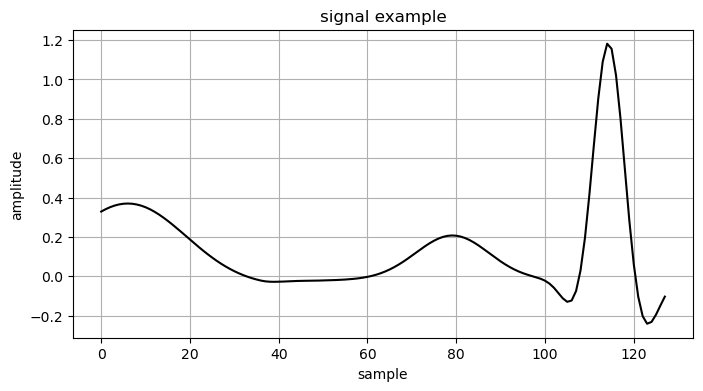

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X[100], c='k')
ax.grid()
ax.set(title='signal example', ylabel='amplitude', xlabel='sample')

In [9]:
D = wavelet_basis(n, basis, level=2)

[Text(0.5, 1.0, 'DWT transform')]

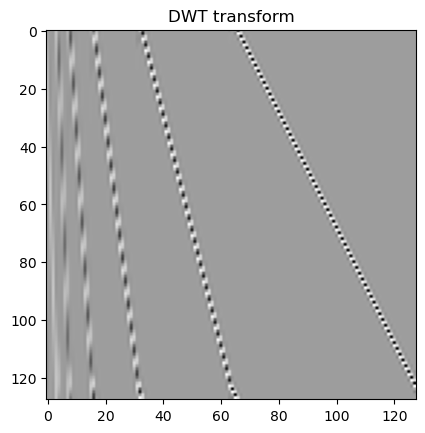

In [10]:
fig, ax = plt.subplots()
ax.imshow(D, cmap='gray')
ax.set(title='DWT transform')

In [11]:
A = generate_sensing_matrix((m, n), seed=seed)
cs = CompressedSensing(A, D)
Y = cs.encode(X)  # measurements

[Text(0.5, 1.0, 'Encoder')]

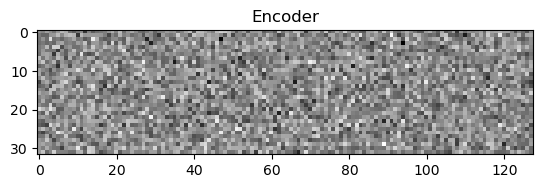

In [12]:
fig, ax = plt.subplots()
ax.imshow(A, cmap='gray')
ax.set(title='Encoder')

In [13]:
XI = X @ cs.D   # sparse representation of the input

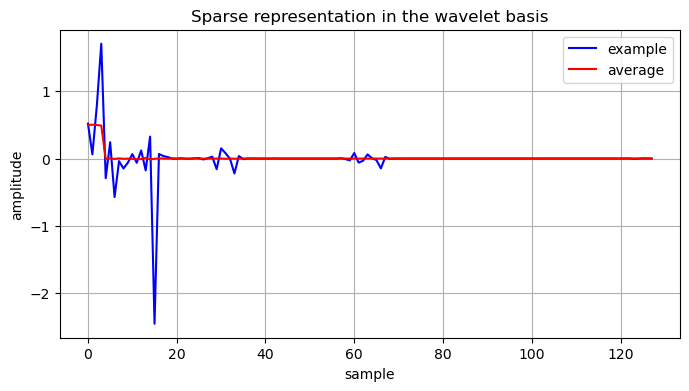

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(XI[100], c='b', label='example')
ax.plot(np.mean(XI, axis=0), c='r', label='average')
ax.set(title='Sparse representation in the wavelet basis',
       ylabel='amplitude', xlabel='sample')
ax.grid()
ax.legend()

In [15]:
# load or compute signal support
data_name = os.path.join('../../newpenny/dnn-cs/JETCAS2020/data/',f'n{n}_ISNR', f'tsSet_n={n}_m={m}_isnr={isnr}-label.h5')
with pd.HDFStore(data_name, mode='r') as store:
    Z = store.select('S').values.squeeze()
    Z = Z[:N_test]
# data_name = f'support_test_N={N_test}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#                 f'_isnr={isnr}_seed={seed}.pkl'
# data_path = os.path.join('test_data', data_name)
# if os.path.exists(data_path):
#     with open(data_path, 'rb') as f:
#         Z = pickle.load(f)
# else:
#     Z = np.array([find_support_TSOC(x, cs) for x in X])
#     with open(data_path, 'wb') as f:
#         pickle.dump(Z, f)

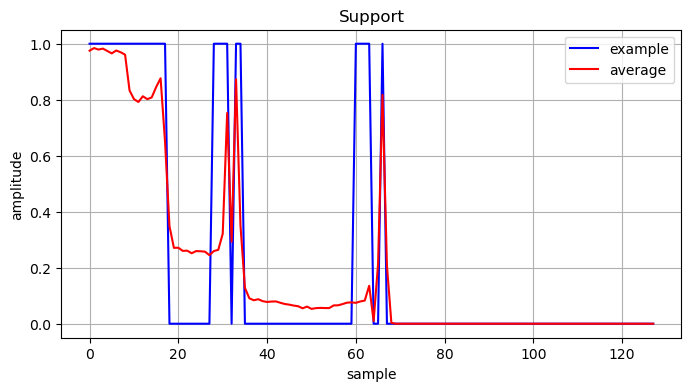

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Z[100], c='b', label='example')
ax.plot(np.mean(Z, axis=0), c='r', label='average')
ax.set(title='Support',
       ylabel='amplitude', xlabel='sample')
ax.grid()
ax.legend()

In [17]:
test_dataset = TensorDataset(torch.from_numpy(Y).float(), torch.from_numpy(Z).float())  # Create a dataset from the tensors
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Evaluation

### Training

In [ ]:
tsoc = TSOC(n, m)
tsoc.to(device) # move the network to GPU
print(tsoc)
file_model = f'TSOC-N={N_train}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
             f'_isnr={isnr}-epochs={epochs}-bs={batch_size}-opt=sgd-lr={lr}'\
             f'_th={threshold}_tf={train_fraction}_minlr={min_lr}-p={patience}'\
             f'_mind={min_delta}_seed={seed}.pth'
tsoc.load_state_dict(torch.load(file_model, weights_only=True))

TSOC(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
)


<All keys matched successfully>

In [19]:
tsoc.eval()     # Set the model to evaluation mode
test_metrics = {'P': 0.0, 'TP': 0.0, 'TPR': 0.0, 'TNR': 0.0, 'ACC': 0.0}
with torch.no_grad():     # disables gradient calculation for the validation phase 
    for batch_idx, (Y_batch, Z_batch) in enumerate(test_loader):
        Y_batch, Z_batch = Y_batch.to(device), Z_batch.to(device)     # move validation data to GPU
        output = tsoc(Y_batch)
        test_metrics_batch = compute_metrics(output, Z_batch, th=threshold)
        test_metrics = update_metrics(test_metrics, test_metrics_batch)

num_batches = len(test_loader)
test_metrics = {key: value / num_batches for key, value in test_metrics.items()}
print(f"  ".join([f'{key}: {np.round(value, 3)}' for key, value in test_metrics.items()])) 


P: 25.206  TP: 24.109  TPR: 0.959  TNR: 0.99  ACC: 0.983


### Recovery

In [20]:
O = torch.empty(X.shape)
for batch_idx, (Y_batch, _) in enumerate(test_loader):
    Y_batch = Y_batch.to(device) 
    O_batch = tsoc(Y_batch)
    O[batch_size*batch_idx: batch_size*(batch_idx + 1)] = O_batch

O = O.cpu().detach().numpy() # Moves the tensor from the GPU to the CPU,
# removes it from the computation graph and converts it to numpy array

<BarContainer object of 20 artists>

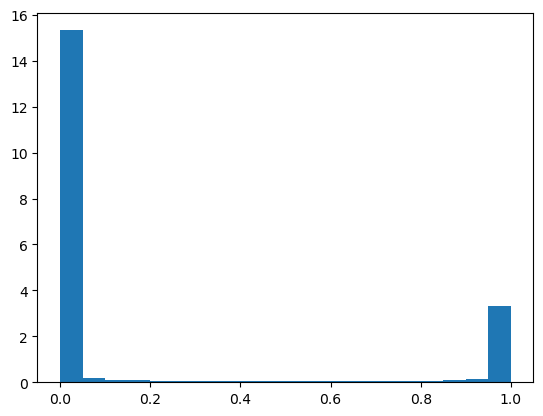

In [21]:
fig, ax = plt.subplots()
ax.hist(O.flatten(), bins = 20, density=True)[-1]

In [22]:
Xhat = np.empty(X.shape)
for i in tqdm.tqdm(range(N_test)):
    Xhat[i] = reconstructor(O[i], Y[i], A, D)

100%|██████████| 10000/10000 [00:04<00:00, 2243.48it/s]


In [23]:
RSNR = compute_rsnr(X, Xhat)
np.mean(RSNR)

29.575114286438026

RSNR: 28.621895541398512


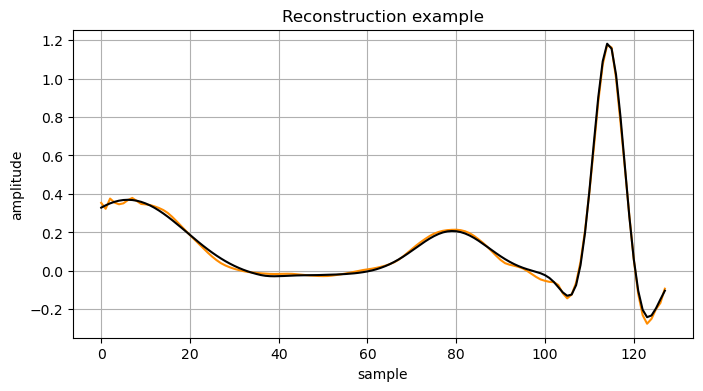

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Xhat[100], c='darkorange', label='xh')
ax.plot(X[100], c='k', label='x')
ax.set(title='Reconstruction example', ylabel='amplitude', xlabel='sample')
ax.grid()
print(f'RSNR: {RSNR[20]}')

### Anomaly Detection

The anomaly detection framework `WOMBATS` works with standardized ($E[x] = 0$, $E[x^2]=1$) signals.

In [25]:
# standarize the data

std, mean = X.std(), X.mean()
Xstd = (X - mean) / std


`delta` is a prior on the difficulty of the anomaly detection task. It is defined w.r.t the standardized signals.

In [26]:
# initialize anomalies


delta_nonstd = std**2 * delta

anomalies_labels = [
    'GWN', 
    'Impulse', 
    'Step', 
    'Constant',  
    'GNN',
    'MixingGWN', 
    'MixingConstant',
    'SpectralAlteration', 
    'PrincipalSubspaceAlteration',
    'TimeWarping',
    'Clipping',
     'Dead-Zone'
]

# # create anomalies class instance
anomalies = [
    GWN(delta),
    Impulse(delta),
    Step(delta),
    Constant(delta),  
    GNN(delta),
    MixingGWN(delta),
    MixingConstant(delta),
    SpectralAlteration(delta),
    PrincipalSubspaceAlteration(delta),
    TimeWarping(delta), 
    Clipping(delta),
    DeadZone(delta)
]

anomalies_dict = dict(zip(anomalies_labels, anomalies))

In [32]:
# initialize the dataframe for anomalous data
Xko_df = pd.DataFrame(
    index=np.arange(N_test),
    columns=pd.MultiIndex.from_product([anomalies_labels, np.arange(n)])
)

Yko_df = pd.DataFrame(
    index=np.arange(N_test),
    columns=pd.MultiIndex.from_product([anomalies_labels, np.arange(m)]),
    dtype=np.float64
)

# generate anomalous data for each anomaly
for anomaly_label, anomaly in tqdm.tqdm(anomalies_dict.items()):
    if anomaly_label in ['SpectralAlteration']:
        anomaly.fit(Xstd, isnr)
    else:
        anomaly.fit(Xstd)
    Xko_std = anomaly.distort(Xstd)
    deltahat = np.mean( (Xstd - Xko_std)**2 )
    print(
        f"\t{anomaly_label} delta={deltahat}"
        )
    Xko = Xko_std*std + mean
    Xko_df[anomaly_label] = Xko
    deltahat = np.mean( (X - Xko)**2 )
    print(
        f"\t{anomaly_label} delta non-std={deltahat}\n"
        )
    Yko = cs.encode(Xko)
    Yko_df[anomaly_label] = Yko

  8%|▊         | 1/12 [00:00<00:01,  6.25it/s]

	GWN delta=0.010011391380585417
	GWN delta non-std=0.0005538748887461116

	Impulse delta=0.010000000000000007


 17%|█▋        | 2/12 [00:00<00:01,  7.00it/s]

	Impulse delta non-std=0.0005532446666905998

	Step delta=0.010000000000000007


 33%|███▎      | 4/12 [00:00<00:01,  5.94it/s]

	Step delta non-std=0.0005532446666905998

	Constant delta=0.010000000000000007
	Constant delta non-std=0.0005532446666905998



 42%|████▏     | 5/12 [00:47<01:59, 17.12s/it]

	GNN delta=0.00988476701277953
	GNN delta non-std=0.0005468694631299449

	MixingGWN delta=0.009993233139303434


 67%|██████▋   | 8/12 [00:48<00:23,  5.80s/it]

	MixingGWN delta non-std=0.0005528702937315383

	MixingConstant delta=0.010000844613434832
	MixingConstant delta non-std=0.0005532913944784227

	SpectralAlteration delta=0.009999000000000006
	SpectralAlteration delta non-std=0.0005531893422239308

	PrincipalSubspaceAlteration delta=0.009999000000000091
	PrincipalSubspaceAlteration delta non-std=0.0005531893422239357



 83%|████████▎ | 10/12 [00:53<00:08,  4.43s/it]

	TimeWarping delta=0.009930749892421827
	TimeWarping delta non-std=0.0005494134414220612



 92%|█████████▏| 11/12 [00:54<00:03,  3.81s/it]

	Clipping delta=0.006420109978727187
	Clipping delta non-std=0.0003551891605297912



100%|██████████| 12/12 [00:57<00:00,  4.75s/it]

	Dead-Zone delta=0.009987269355190164
	Dead-Zone delta non-std=0.0005525403505561418



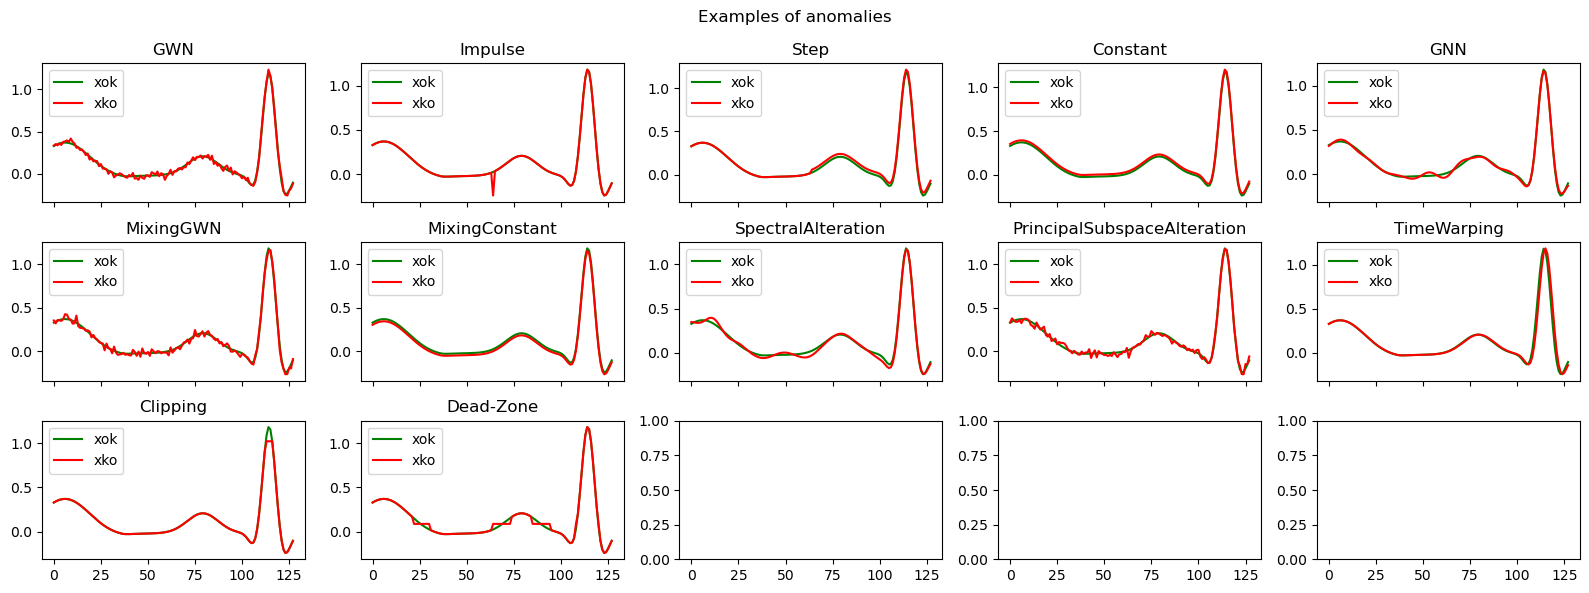

In [33]:
fig, ax = plt.subplots(3, 5, figsize=(16, 6), sharex=True, sharey=False)
ax = ax.flatten()
for name, ax_ in zip(anomalies_dict.keys(), ax):
    ax_.plot(X[100], label='xok', c='g')
    ax_.plot(Xko_df.loc[100, name], label=f'xko', c='r')
    ax_.legend()
    ax_.set(title=name)
fig.suptitle('Examples of anomalies')
fig.tight_layout()


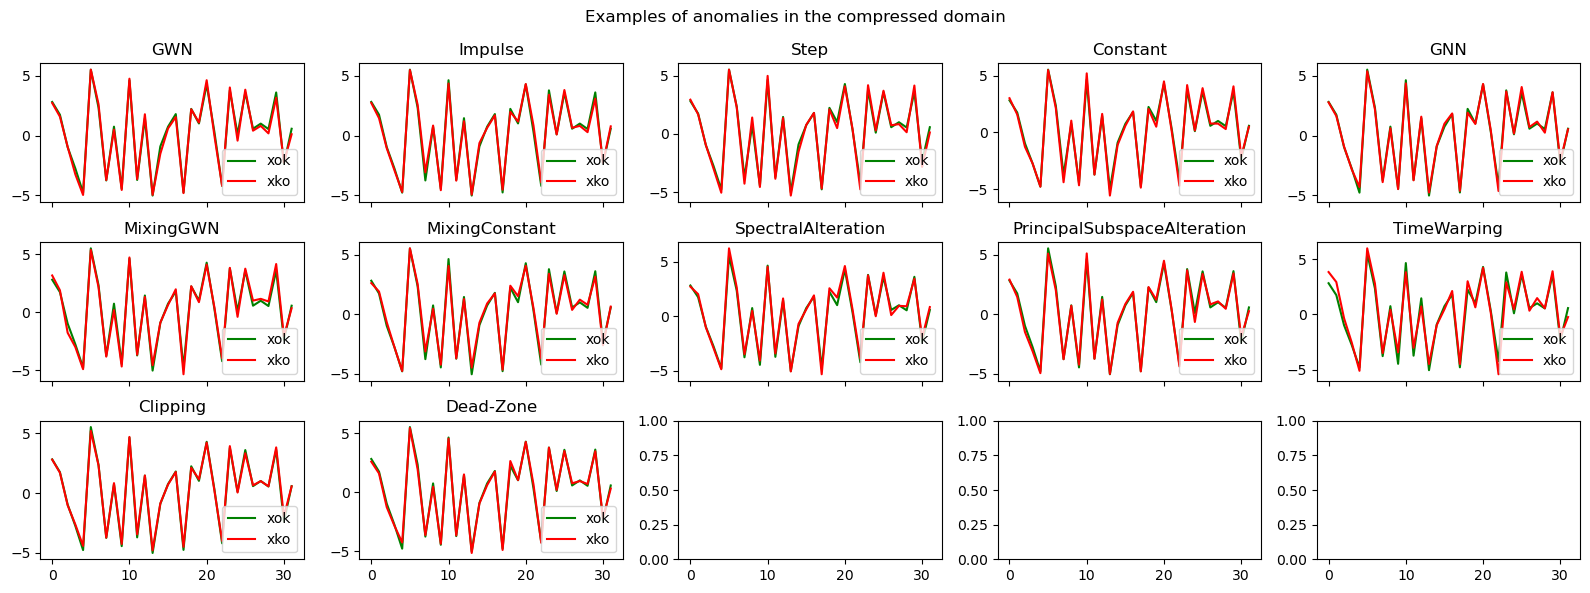

In [34]:
fig, ax = plt.subplots(3, 5, figsize=(16, 6), sharex=True, sharey=False)
ax = ax.flatten()
for name, ax_ in zip(anomalies_dict.keys(), ax):
    ax_.plot(Y[100], label='xok', c='g')
    ax_.plot(Yko_df.loc[100, name], label=f'xko', c='r')
    ax_.legend()
    ax_.set(title=name)
fig.suptitle('Examples of anomalies in the compressed domain')
fig.tight_layout()

Reconstruct the signal and then re-compress it. The distance between compresesd and recompressed signals is used as anomaly score. 

Classical autoencoder-like score (distance between the signal and its reconstruction) is also used for comparison.

In [35]:
# Evaluate detection performance

Xko_hat_df = pd.DataFrame(
    index=np.arange(N_test),
    columns=pd.MultiIndex.from_product([anomalies_labels, np.arange(n)]),
    dtype=np.float64
)

Yko_hat_df = pd.DataFrame(
    index=np.arange(N_test),
    columns=pd.MultiIndex.from_product([anomalies_labels, np.arange(m)]),
    dtype=np.float64
)

score_df = pd.DataFrame(
    index=np.arange(int(2*N_test)),
    columns=anomalies_labels,
    dtype=np.float64
)

AUCdf = pd.Series(index=anomalies_labels, dtype=np.float64)

score_df2 = pd.DataFrame(
    index=np.arange(int(2*N_test)),
    columns=anomalies_labels,
    dtype=np.float64
)

AUCdf2 = pd.Series(index=anomalies_labels, dtype=np.float64)

Yhat = cs.encode(Xhat)

# Use TSOC as a detector of anomalies
for anomaly_label in tqdm.tqdm(anomalies_labels):
    Xko = Xko_df[anomaly_label].values
    # Yko_hat = detector(tsoc, cs, Xko, A, D)
    Xanom = np.concatenate([X, Xko])

    Yko = cs.encode(Xko)
    Yanom = np.concatenate([Y, Yko])

    anomaly_dataset = TensorDataset(torch.from_numpy(Yko).float())  # Create a dataset from the tensors
    anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, shuffle=False)
    O = torch.empty(X.shape)
    for batch_idx, Y_batch in enumerate(anomaly_loader):
        Y_batch = Y_batch[0].to(device) 
        O_batch = tsoc(Y_batch)
        O[batch_size*batch_idx: batch_size*(batch_idx + 1)] = O_batch

    O = O.cpu().detach().numpy()
    Xko_hat = np.empty(X.shape)
    for i in tqdm.tqdm(range(N_test)):
        Xko_hat[i] = reconstructor(O[i], Yko[i], A, D)

    Xko_hat_df[anomaly_label] = Xko_hat

    Xanom_hat = np.concatenate([Xhat, Xko_hat])
    
    Yko_hat = cs.encode(Xko_hat)
    Yko_hat_df[anomaly_label] = Yko_hat
    Yanom_hat = np.concatenate([Yhat, Yko_hat])

    # Yanom_hat = cs.encode(Xanom)

    score = np.sqrt(np.sum((Yanom_hat - Yanom)**2, axis = -1))
    
    score_df[anomaly_label] = score
    AUCdf[anomaly_label] = np.round(AUC(score), 3)

    score2 = np.sqrt(np.sum((Xanom_hat - Xanom)**2, axis = -1))
    
    score_df2[anomaly_label] = score2
    AUCdf2[anomaly_label] = np.round(AUC(score2), 3)

    

100%|██████████| 12/12 [01:07<00:00,  5.62s/it]


In [37]:
# Init TSOC-based detectors

tsoc_detectors_labels = [f'TSOC_SA', 'TSOC_AE']
tsoc_detectors = [TSOCDetector(n, m, file_model, seed, mode='self-assessment', gpu=device),
                  TSOCDetector(n, m, file_model, seed, mode='autoencoder', gpu=device)]
tsoc_detectors_dict = dict(zip(tsoc_detectors_labels, tsoc_detectors))

# Fit TSOC-based detectors
for detector_label, detector in tsoc_detectors_dict.items():
    tsoc_detectors_dict[detector_label] = detector.fit()
    
# Evaluate TSOC-based detectors

result = pd.DataFrame(index=anomalies_labels, columns=tsoc_detectors_labels, dtype=np.float64)

for detector_label, detector in tsoc_detectors_dict.items():
    for anomaly_label in tqdm.tqdm(anomalies_labels):
        Xko = Xko_df[anomaly_label].values
        Xanom = np.concatenate([X, Xko])
        metric_value = detector.test(Xanom, metric='AUC')
        result.loc[anomaly_label, detector_label] = np.round(metric_value, 3)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [02:05<00:00, 10.47s/it]


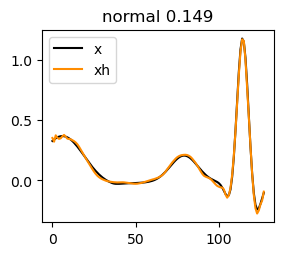

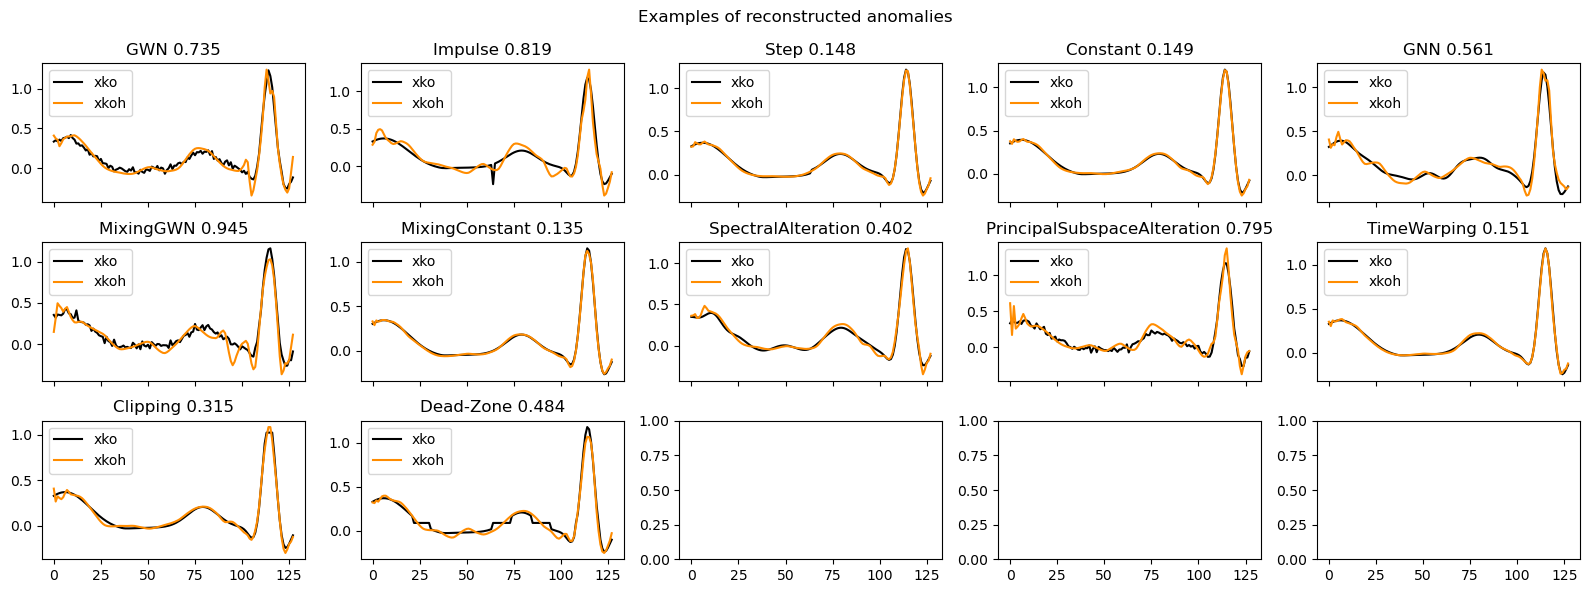

In [38]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.plot(X[100], label='x', c='k')
ax.plot(Xhat[100], label=f'xh', c='darkorange')
ax.legend()
ax.set(title = f'normal {np.round(score_df2.loc[100, anomalies_labels[0]], 3)}')

fig, ax = plt.subplots(3, 5, figsize=(16, 6), sharex=True, sharey=False)
ax = ax.flatten()
for name, ax_ in zip(anomalies_dict.keys(), ax):
    ax_.plot(Xko_df.loc[100, name], label='xko', c='k')
    ax_.plot(Xko_hat_df.loc[100, name], label=f'xkoh', c='darkorange')
    ax_.legend()
    ax_.set(title = f'{name} {np.round(score_df2.loc[N_test+100, name], 3)}')
fig.suptitle('Examples of reconstructed anomalies')
fig.tight_layout()

In [39]:
score_df2

,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone
0,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362,0.029362
1,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613,0.203613
2,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991,0.085991
3,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089,0.046089
4,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184,0.108184
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.164766,0.713564,0.336295,0.205997,0.650276,0.884025,0.204968,0.419595,0.664591,0.187063,0.416781,1.338467
19996,0.600865,0.788203,0.073160,0.058496,0.136177,0.477962,0.074973,0.098591,0.430947,0.064522,0.073792,0.393413
19997,0.373796,0.414705,0.066888,0.042005,0.803559,0.342771,0.041795,0.048636,0.260861,0.045422,0.040264,0.331172
19998,0.558683,0.625632,0.174715,0.158585,0.627285,0.736089,0.157792,0.282272,1.114102,0.222389,0.293074,0.555812


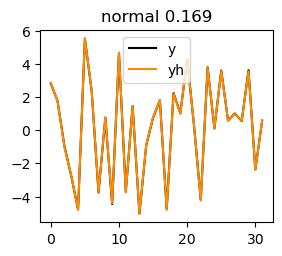

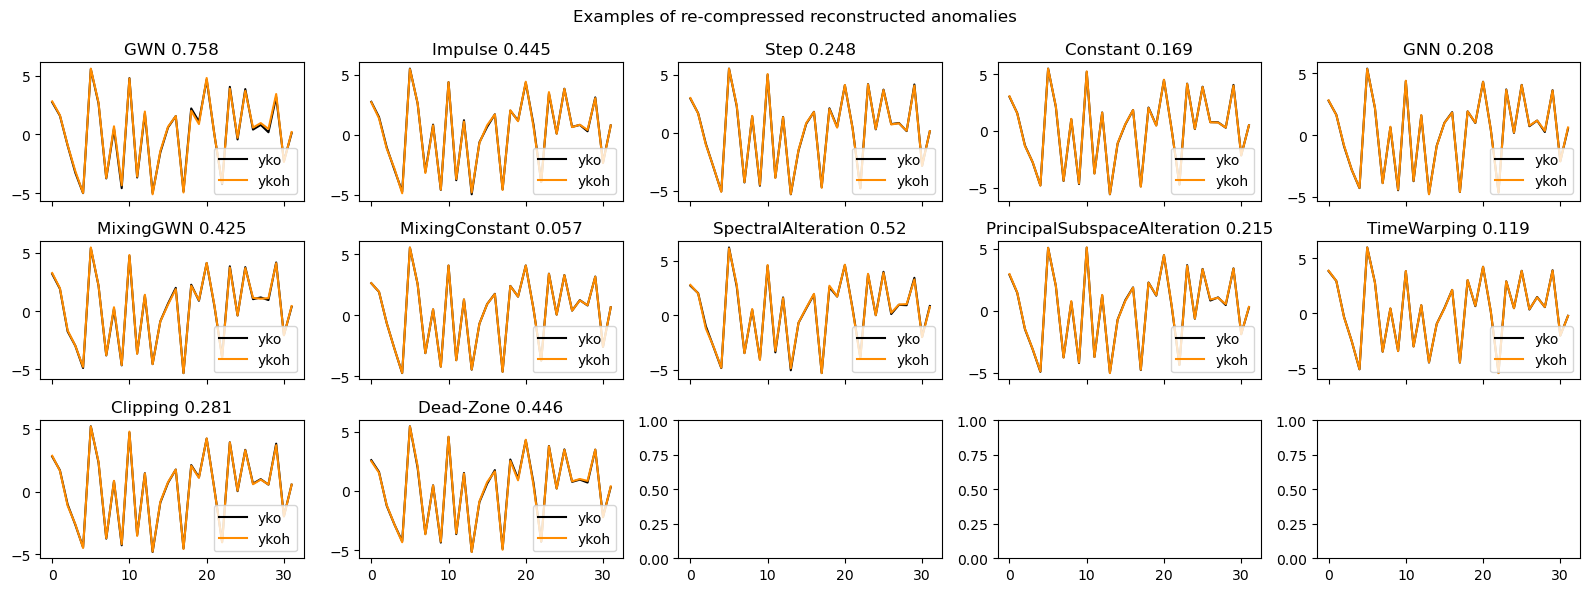

In [40]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.plot(Y[100], label='y', c='k')
ax.plot(Yhat[100], label=f'yh', c='darkorange')
ax.set(title = f'normal {np.round(score_df.loc[100, anomalies_labels[0]], 3)}')
ax.legend()

fig, ax = plt.subplots(3, 5, figsize=(16, 6), sharex=True, sharey=False)
ax = ax.flatten()
for name, ax_ in zip(anomalies_dict.keys(), ax):
    ax_.plot(Yko_df.loc[100, name], label='yko', c='k')
    ax_.plot(Yko_hat_df.loc[100, name], label=f'ykoh', c='darkorange')
    ax_.legend()
    ax_.set(title = f'{name} {np.round(score_df.loc[N_test+100, name], 3)}')
fig.suptitle('Examples of re-compressed reconstructed anomalies')
fig.tight_layout()

In [41]:
score_df

,GWN,Impulse,Step,Constant,GNN,MixingGWN,MixingConstant,SpectralAlteration,PrincipalSubspaceAlteration,TimeWarping,Clipping,Dead-Zone
0,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406,0.077406
1,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038,0.064038
2,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444,0.121444
3,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286,0.072286
4,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700,0.146700
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.655283,0.503968,0.232971,0.120121,0.559472,0.465293,0.119520,0.260903,0.727481,0.334277,0.426188,0.384950
19996,1.041970,0.642924,0.132083,0.117842,0.202135,0.448328,0.067506,0.086532,0.875347,0.095259,0.153524,0.369267
19997,0.784889,0.744393,0.155886,0.092583,0.808928,0.549592,0.092120,0.105920,0.408987,0.097879,0.092861,0.466006
19998,0.708446,0.754670,0.238887,0.223495,0.163984,0.996963,0.222377,0.154176,0.520563,0.269267,0.226594,0.270346


In [44]:
result['CS'] = AUCdf
result['AE'] = AUCdf2

In [ ]:
# Train other detectors

nu = 0.01
kernel = 'rbf'
h = 20
l = 100
p = 4
k = 10

detectors_labels = [f'SPE_{k}', f'T2_{k}', f'AR_{p}', f'OCSVM_{kernel}_{nu}', f'LOF_{h}',f'IF_{l}', 'MD', 'energy', 'TV', 'ZC', 'pk-pk']
detectors = [SPE(k), T2(k), AR(p), OCSVM(kernel, nu), LOF(h), IF(l), MD(), energy(), TV(), ZC(), pk_pk()]
detectors_dict = dict(zip(detectors_labels, detectors))

# data_name = f'ecg_train_N={N_train}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
#                 f'_isnr={isnr}_seed={seed}.pkl'
# data_path = os.path.join('training_data', data_name)
# with open(data_path, 'rb') as f:
#     X_train = pickle.load(f)
data_name = os.path.join('../../newpenny/dnn-cs/JETCAS2020/data/',f'n{n}_ISNR', f'trSet_n={n}_isnr={isnr}_no-sparse.h5')
with pd.HDFStore(data_name, mode='r') as store:
    X_train = store.select('X').values.squeeze()
Y_train = cs.encode(X_train)

train_size = int(train_fraction * len(Y_train))  # 80% for training
val_size = len(Y_train) - train_size  # 20% for validation

# Split the dataset into training and validation
generator = torch.Generator()
generator.manual_seed(seed)
train_dataset, val_dataset = random_split(Y_train, [train_size, val_size], generator=generator)
Y_train, Y_val = train_dataset.dataset, val_dataset.dataset
    

for detector_label, detector in tqdm.tqdm(detectors_dict.items()):
    # model_name = f'{detector_label}_N={600_000}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
                # f'_isnr={isnr}_seed={seed}.pkl'
    model_name = f'{detector_label}_N={N_train}_n={n}_fs={fs}_hr={heart_rate[0]}-{heart_rate[1]}'\
    f'_isnr={isnr}_seed={seed}.pkl'
    model_path = os.path.join('detectors', model_name)
    if os.path.exists(model_path):
        # load
        with open(model_path, 'rb') as f:
            detectors_dict[detector_label] = pickle.load(f)
    else:
        detectors_dict[detector_label] = detector.fit(Y_train)
        # save
        with open(model_path,'wb') as f:
            pickle.dump(detectors_dict[detector_label], f)

100%|██████████| 11/11 [00:00<00:00, 17.00it/s]


In [49]:
# Evaluate other detectors

# result = pd.DataFrame(index=anomalies_labels, columns=detectors_labels, dtype=np.float64)

for detector_label, detector in tqdm.tqdm(detectors_dict.items()):
    for anomaly_label in anomalies_labels:
        Xko = Xko_df[anomaly_label].values
        Yko = cs.encode(Xko)
        Yanom = np.concatenate([Y, Yko])
        metric_value = detector.test(Yanom, metric='AUC')
        result.loc[anomaly_label, detector_label] = np.round(metric_value, 3)

100%|██████████| 11/11 [01:26<00:00,  7.87s/it]


In [50]:
(1-result).style.background_gradient(cmap=cmap_auc, vmin=0, vmax=1)

,TSOC_SA,TSOC_AE,CS,AE,SPE_10,T2_10,AR_4,OCSVM_rbf_0.01,LOF_20,IF_100,MD,energy,TV,ZC,pk-pk
GWN,0.980000,0.985000,0.980000,0.985000,0.524000,0.502000,0.504000,0.487000,0.412000,0.492000,0.922000,0.504000,0.504000,0.503000,0.504000
Impulse,0.982000,0.984000,0.982000,0.984000,0.524000,0.501000,0.504000,0.489000,0.429000,0.493000,1.000000,0.504000,0.503000,0.500000,0.504000
Step,0.700000,0.619000,0.700000,0.619000,0.502000,0.504000,0.506000,0.487000,0.480000,0.492000,0.520000,0.505000,0.506000,0.503000,0.505000
Constant,0.500000,0.500000,0.500000,0.500000,0.500000,0.502000,0.504000,0.493000,0.513000,0.493000,0.501000,0.504000,0.504000,0.502000,0.504000
GNN,0.947000,0.948000,0.947000,0.948000,0.523000,0.503000,0.504000,0.487000,0.416000,0.492000,0.853000,0.504000,0.505000,0.502000,0.504000
MixingGWN,0.982000,0.985000,0.982000,0.985000,0.522000,0.497000,0.500000,0.496000,0.415000,0.497000,0.921000,0.500000,0.500000,0.502000,0.500000
MixingConstant,0.499000,0.498000,0.499000,0.498000,0.497000,0.497000,0.499000,0.503000,0.518000,0.497000,0.496000,0.499000,0.499000,0.503000,0.500000
SpectralAlteration,0.818000,0.765000,0.818000,0.765000,0.507000,0.506000,0.506000,0.483000,0.426000,0.493000,0.523000,0.507000,0.507000,0.504000,0.504000
PrincipalSubspaceAlteration,0.986000,0.961000,0.986000,0.961000,0.511000,0.498000,0.501000,0.490000,0.434000,0.494000,0.868000,0.503000,0.499000,0.499000,0.497000
TimeWarping,0.494000,0.495000,0.494000,0.495000,0.496000,0.500000,0.500000,0.501000,0.501000,0.500000,0.491000,0.500000,0.500000,0.500000,0.500000


In [51]:
results_pd = 0.5 + np.abs(0.5 - result)

In [52]:
results_pd.style.background_gradient(cmap=cmap_pd, vmin=0.5, vmax=1)

,TSOC_SA,TSOC_AE,CS,AE,SPE_10,T2_10,AR_4,OCSVM_rbf_0.01,LOF_20,IF_100,MD,energy,TV,ZC,pk-pk
GWN,0.980000,0.985000,0.980000,0.985000,0.524000,0.502000,0.504000,0.513000,0.588000,0.508000,0.922000,0.504000,0.504000,0.503000,0.504000
Impulse,0.982000,0.984000,0.982000,0.984000,0.524000,0.501000,0.504000,0.511000,0.571000,0.507000,1.000000,0.504000,0.503000,0.500000,0.504000
Step,0.700000,0.619000,0.700000,0.619000,0.502000,0.504000,0.506000,0.513000,0.520000,0.508000,0.520000,0.505000,0.506000,0.503000,0.505000
Constant,0.500000,0.500000,0.500000,0.500000,0.500000,0.502000,0.504000,0.507000,0.513000,0.507000,0.501000,0.504000,0.504000,0.502000,0.504000
GNN,0.947000,0.948000,0.947000,0.948000,0.523000,0.503000,0.504000,0.513000,0.584000,0.508000,0.853000,0.504000,0.505000,0.502000,0.504000
MixingGWN,0.982000,0.985000,0.982000,0.985000,0.522000,0.503000,0.500000,0.504000,0.585000,0.503000,0.921000,0.500000,0.500000,0.502000,0.500000
MixingConstant,0.501000,0.502000,0.501000,0.502000,0.503000,0.503000,0.501000,0.503000,0.518000,0.503000,0.504000,0.501000,0.501000,0.503000,0.500000
SpectralAlteration,0.818000,0.765000,0.818000,0.765000,0.507000,0.506000,0.506000,0.517000,0.574000,0.507000,0.523000,0.507000,0.507000,0.504000,0.504000
PrincipalSubspaceAlteration,0.986000,0.961000,0.986000,0.961000,0.511000,0.502000,0.501000,0.510000,0.566000,0.506000,0.868000,0.503000,0.501000,0.501000,0.503000
TimeWarping,0.506000,0.505000,0.506000,0.505000,0.504000,0.500000,0.500000,0.501000,0.501000,0.500000,0.509000,0.500000,0.500000,0.500000,0.500000
